IMPORT LIB

In [237]:
import pickle
import numpy as np

# clustering 
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#affichage
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

CHARGEMENT pickle_raw

In [90]:
with open('../data/embeddings/my_dict.pckl', 'rb') as f:
    emb_raw = pickle.load(f)
print(len(list(emb_raw)))

32960


In [268]:
# emb_raw

In [216]:
# get a list of the filenames
filenames = np.array(list(emb_raw.keys()))

# get a list of just the features
feat = np.array(list(emb_raw.values()))
feat = feat.reshape(-1,4096)

REDUCTION DIMENSION (n=200 -> 79.2% d'explicabilité)

In [271]:
from umap import UMAP

reducer = UMAP(n_components=100, random_state=22)
x_umap = reducer.fit_transform(feat)

In [273]:
kmeans = KMeans(n_clusters=2, random_state=22)
kmeans.fit(x_umap)

/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=22)

In [219]:
pca = PCA(n_components=200, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
sum(pca.explained_variance_ratio_)

0.7921275198750664

ENREGISTREMENT pickle_light

In [218]:
# emb_light={}
# for name in filenames:
#     emb_light[name] = x;

# with open('emb_light.pckl', 'wb') as f:
#     pickle.dump(emb_light, f)

COSIN SIMILILARITIES

In [165]:
# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(x)

CLUSTERING

In [270]:
kmeans = KMeans(n_clusters=2, random_state=22)
# kmeans.fit(x)
kmeans.fit(cosine_sim)

/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Traceback (most recent call last):
  File "/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/IPython/core/ultratb.

Unexpected exception formatting exception. Falling back to standard exception


KMeans(n_clusters=2, random_state=22)

In [274]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
        
print(f"sur {len(data)} images analysées.")
print(f"il y a {len(groups)} clusters.\n")

for i in range(len(groups)):
    print(f"Nb images dans le {i}eme cluster : {len(groups[i])}")

sur 32960 images analysées.
il y a 2 clusters.

Nb images dans le 0eme cluster : 16953
Nb images dans le 1eme cluster : 16007


In [275]:
# pca2 = PCA(n_components=2)
# xx = pca2.fit_transform(x)

tsne = TSNE(n_components=2)
xx = tsne.fit_transform(x)

In [276]:
xx0 = xx[kmeans.labels_ == 0]
len(xx0)

16953

In [277]:
xx1 = xx[kmeans.labels_ == 1]
len(xx1)

16007

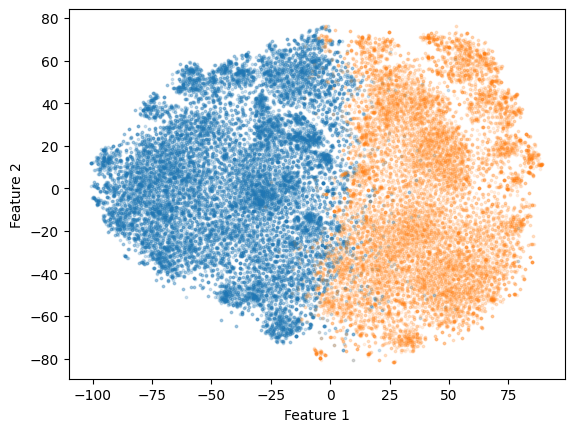

In [278]:
fig, ax = plt.subplots()

#print cluster 0 en bleu
scatter = ax.scatter(xx0[:, 0], xx0[:, 1], alpha=.2, c='C0', s=3)
#print cluster 1 en orange
ax.scatter(xx1[:, 0], xx1[:, 1], alpha=.1, c='C1', s=3)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

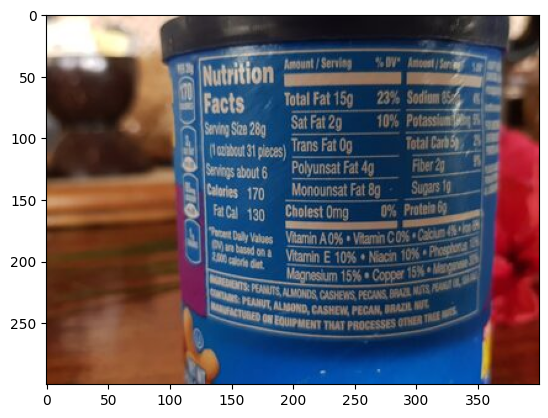

In [279]:
#[nb cluster][nb image]
file='../data/images/'+groups[0][3]
img = mpimg.imread(file)
plt.imshow(img)
plt.show()

CREATION DATAFRAME

In [ ]:
# 'ID:nom_fichier', 'embeddings_proj2D', 'bool_etiquette'  

In [261]:
dataframe=[]
for i in range(len(groups)):
    if i==0:
        for j in zip(filenames, "class_"+str(i), xx0):
            dataframe.append(j)
    else:
        for j in zip(filenames,'class_'+str(i),xx1):
            dataframe.append(j)